# Denoising

In [2]:
import os
import subprocess
from src.utils import get_command_defaults, ensure_dir, write_yaml, update_yaml
from src.train import load_model, train_model, run_epoch
from src.data import load_dataset, SystemFamily
from src.train._losses import *

## Generate noisy data
First, we generate both the training and testing sets. The former will be a set of vector fields corresponding to polynomial ODEs of degree at most 3 and having sparse coefficients. The testing set will be vector fields representing the flows of 10 types of sytsems drawn from across the sciences. In all cases, we work with planar (i.e. two-dimensional systems). 

First, we set some basic parameters, including the types of training and testing data and the number of their samples. 

In [34]:
## Generate data

data_dir = '/home/mgricci/data/phase2vec' # Alter to change where all of the phase2vec data will be saved. 

# Edit the data included in training and testing here. 
noise_data_names  = ['saddle_node', 'pitchfork', 'transcritical',
                    'selkov', 'homoclinic', 'vanderpol',
                    'simple_oscillator', 'fitzhugh_nagumo', 'lotka_volterra']
noise_type = 'trajectory'
noise_mag=2000
tt = 1.0
alpha = .01
device='cpu'
num_samples = 100

noise_system_classes = []
for system in [SystemFamily(data_name=name) for name in noise_data_names]:
    noise_system_classes += [system.data_name + ' ' + str(i) for i in range(len(system.param_groups))]

samplers    = ['uniform'] * len(noise_data_names)
props       = [str(1. / len(noise_data_names))] * len(noise_data_names)
noise_data_names   = '-s ' +  ' -s '.join(noise_data_names)
samplers     = '-sp ' +  ' -sp '.join(samplers)
props = '-c ' +  ' -c '.join(props)

subprocess.call(f'phase2vec generate-dataset --data-dir {data_dir} --data-set-name classical_noise_type_{noise_type}_mag_{noise_mag} --noise-type {noise_type} --noise-mag {noise_mag} --num-samples {num_samples} {noise_data_names} {samplers} {props} --tt {tt} --alpha {alpha} ', shell=True)

Generating saddle_node data.
Generating pitchfork data.
Generating transcritical data.
Generating selkov data.
Generating homoclinic data.
Generating vanderpol data.
Generating simple_oscillator data.
Generating fitzhugh_nagumo data.
Generating lotka_volterra data.
(92,)


0

In [6]:
## Generate clean data
subprocess.call(f'phase2vec generate-dataset --data-dir {data_dir} --data-set-name classical_no_noise --num-samples {num_samples} {noise_data_names} {samplers} {props}', shell=True)

Generating saddle_node data.
Generating pitchfork data.
Generating transcritical data.
Generating selkov data.
Generating homoclinic data.
Generating vanderpol data.
Generating simple_oscillator data.
Generating fitzhugh_nagumo data.
Generating lotka_volterra data.
(92,)


0

In [35]:
import numpy as np

# Load noisy data
noisy_data_path = os.path.join(data_dir, f'classical_noise_type_{noise_type}_mag_{noise_mag}')
# noise_data_path = os.path.join(data_dir, 'simple_oscillator')
X_noisy1, X_noisy2, y_noisy1, y_noisy2, p_noisy1, p_noisy2 = load_dataset(noisy_data_path)
X_noisy = np.concatenate([X_noisy1, X_noisy2])
y_noisy = np.concatenate([y_noisy1, y_noisy2])
p_noisy = np.concatenate([p_noisy1, p_noisy2])

# Load clean data
clean_data_path = os.path.join(data_dir, f'classical_no_noise')
X_clean1, X_clean2, y_clean1, y_clean2, p_clean1, p_clean2 = load_dataset(clean_data_path)
X_clean = np.concatenate([X_clean1, X_clean2])
y_clean = np.concatenate([y_clean1, y_clean2])
p_clean = np.concatenate([p_clean1, p_clean2])

Next, we call the actual shell commands for generating the data. These commands will make two directories, called `polynomial` and `classical`, corresponding to train and test sets, inside your `data_dir`. 

In order to alter the validation proportion, $p$, add the flag `--val-size <p>` where $p\in (0,1)$. 

In [36]:
## Set net parameters
from src.cli._cli import generate_net_config

net_info = get_command_defaults(generate_net_config)
model_type = net_info['net_class']
model_save_dir  = os.path.join('/home/mgricci/phase2vec/', 'basic_train')

# These parameters are not considered architectural parameters for the net, so we delete them before they're passed to the net builder. 
del net_info['net_class']
del net_info['output_file']
del net_info['pretrained_path']
del net_info['ae']

net = load_model(model_type, pretrained_path=os.path.join(model_save_dir, 'model.pt'), device=device, **net_info).to(device)
net.eval()

CNNwFC_exp_emb(
  (enc): CNN(
    (conv_layers): Sequential(
      (0): Conv2d(2, 128, kernel_size=(3, 3), stride=(2, 2))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2))
      (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU()
    )
  )
  (emb): MLP(
    (layers): Sequential(
      (0): Linear(in_features=6272, out_features=100, bias=True)
    )
  )
  (dec): MLP(
    (layers): Sequential(
      (0): Linear(in_features=100, out_features=128, bias=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0.1, inplace=False)
      (4): Linear(in_features=128, out_fea

## Evaluate average performance on each data set. 

In [37]:

# ## Evaluate
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn import linear_model
import pdb
loss_dict = {}
sorted_data = []
sorted_data_clean = []
recon_dict = {'p2v':[],'lasso':[]}
fp_normalize = False

euclidean = normalized_euclidean if fp_normalize else euclidean_loss

net.eval()
for label in tqdm(np.unique(y_noisy)):
    
    # Noisy data for this class
    data_noisy   = torch.tensor([datum for (d, datum) in enumerate(X_noisy) if y_noisy[d] == label])
    pars_noisy   = torch.tensor([par for (p, par) in enumerate(p_noisy) if y_noisy[p] == label])
    labels = torch.ones(len(data_noisy)) * label
    
    sorted_data += list(data_noisy)
    
    # Clean data for this class
    data_clean   = torch.tensor([datum for (d, datum) in enumerate(X_clean) if y_clean[d] == label])
    pars_clean   = torch.tensor([par for (p, par) in enumerate(p_clean) if y_clean[p] == label])
    labels_clean = torch.ones(len(data_clean)) * label
    
    sorted_data_clean += list(data_clean)
    
    # Both the p2v and lasso loss for this class
    class_par_losses = []
    class_recon_losses = []
    # For each fitting method
    for nm, forward in zip(recon_dict.keys(),[forward_p2v, forward_lasso]):
        
        # Fit pars and return recon
        pars_fit, recon = forward(net, data_noisy.float())
    
        # Par loss
        par_loss   = euclidean_loss(pars_fit, pars_clean).detach().cpu().numpy()
        # Recon loss
        recon_loss = euclidean(recon, data_clean).detach().cpu().numpy()
        class_par_losses.append(par_loss)
        class_recon_losses.append(recon_loss) 
        
        recon_dict[nm] += list(recon)    
    loss_dict[noise_system_classes[label]] = class_recon_losses + class_par_losses
df = pd.DataFrame(data=loss_dict)
df.index = [ 'Recon-P2V', 'Recon-LASSO', 'Param-P2V', 'Param-LASSO']

2.3723102
3.948167


In [ ]:
df

## Visualize Reconstructions
Finally, let's plot the first two PCA components of the embeddings. 

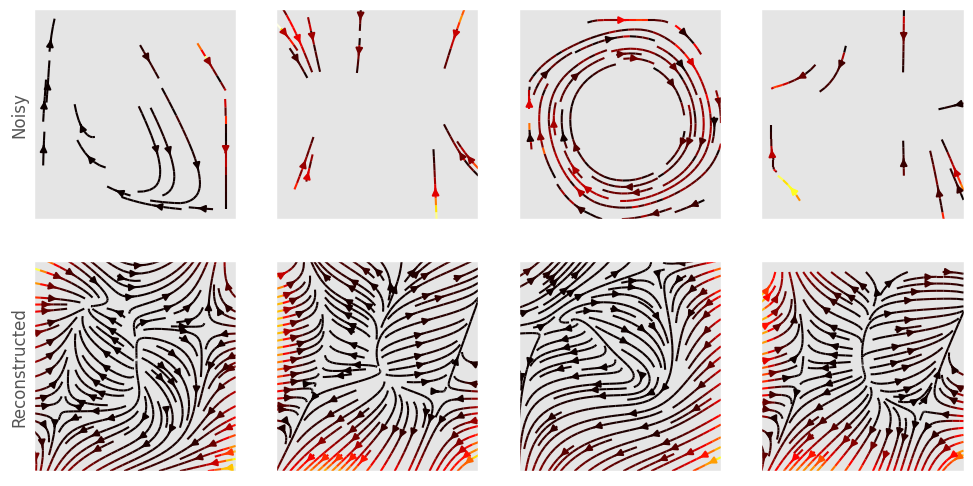

In [28]:
# Get embedding inds
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import pdb

num_data = X_noisy.shape[0]
num_lattice = X_noisy.shape[2]

x = np.linspace(-1.0,1.0, num_lattice)
y = np.linspace(-1.0,1.0,num_lattice)

num_vis = 4
# vis_inds = np.random.permutation(num_data)[:num_vis]
fig, axes = plt.subplots(4,4,figsize=(12,12))

vis_data = [sorted_data[ind].detach().numpy() for ind in vis_inds]
vis_clean = [sorted_data_clean[ind].detach().numpy() for ind in vis_inds]
vis_recons_lasso = [recon_dict['lasso'][ind].detach().numpy() for ind in vis_inds]
vis_recons_p2v = [recon_dict['p2v'][ind].detach().numpy() for ind in vis_inds]

for a, (col, clean, noisy, recon_lasso, recon_p2v) in enumerate(zip(axes.T, vis_clean, vis_data, vis_recons_lasso, vis_recons_p2v)):
    for row, arr, nm in zip(col, [clean, noisy, recon_lasso, recon_p2v], ['Clean', 'Noisy', 'Recon-LASSO', 'Recon-P2V']):
        arr = arr.transpose(0,2,1)

        row.streamplot(x,y,arr[0],arr[1],color=(arr**2).sum(0), cmap='hot')
        if a == 0:
            row.set_ylabel(nm)
    for ax in col:
        ax.grid(b=None)
        ax.set_xticks([])
        ax.set_yticks([])

plt.show()
plt.close()